In [1]:
# --- Install dependencies if needed ---
# !pip install ib_insync nest_asyncio pandas_datareader plotly filterpy arch

# Simplify all the features for KNN, and set it to trade based on specifc HMM -- maybe even just apply to stock or single option, make the data pull fast and minimize run time. Use Gamma, theta, IV garch, MACD, Bollinger, RSI, maybe an SMA filter, lorentzian knn
import nest_asyncio
nest_asyncio.apply()

import asyncio
from ib_insync import *
import pandas as pd
import numpy as np
from filterpy.kalman import KalmanFilter
from scipy.stats import norm
from scipy.optimize import brentq
import pandas_datareader.data as web
import datetime
import plotly.graph_objects as go

# --- PARAMETERS ---
numbars = 3600
durationStr = '7 D'
barSizeSetting = '5 mins'
symbol1 = 'TSLA'
lastTradeDateOrContractMonth1 = '20250718'
strike1 = 310
right1 = 'P'
symbol2 = 'TSLA'
lastTradeDateOrContractMonth2 = '20250718'
strike2 = 300
right2 = 'P'

# --- FETCH FUNCTION ---
async def fetch_option(symbol, lastTradeDateOrContractMonth, strike, right, num_bars):
    ib = IB()
    await ib.connectAsync('127.0.0.1', 7496, clientId=np.random.randint(1000, 10000))
    option_contract = Option(
        symbol=symbol,
        lastTradeDateOrContractMonth=lastTradeDateOrContractMonth,
        strike=strike,
        right=right,
        exchange='SMART',
        currency='USD'
    )
    await ib.qualifyContractsAsync(option_contract)
    stock_contract = Stock(symbol, 'SMART', 'USD')
    await ib.qualifyContractsAsync(stock_contract)
    all_bars = []
    end_time = ''
    while len(all_bars) < num_bars:
        bars = await ib.reqHistoricalDataAsync(
            contract=option_contract,
            endDateTime=end_time,
            durationStr=durationStr,
            barSizeSetting=barSizeSetting,
            whatToShow='TRADES',
            useRTH=True,
            formatDate=1
        )
        if not bars:
            print("No more bars available.")
            break
        all_bars = bars + all_bars
        end_time = (bars[0].date - pd.Timedelta(minutes=1)).strftime('%Y%m%d %H:%M:%S')
        await asyncio.sleep(10)
    all_bars = all_bars[-num_bars:]
    df = util.df(all_bars)
    df.set_index('date', inplace=True)
    stock_bars = await ib.reqHistoricalDataAsync(
        contract=stock_contract,
        endDateTime='',
        durationStr=durationStr,
        barSizeSetting=barSizeSetting,
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1
    )
    stock_df = util.df(stock_bars)
    stock_df.set_index('date', inplace=True)
    df['stock price'] = stock_df['close'].reindex(df.index, method='ffill')
    df.rename(columns={
        'close': 'Close',
        'volume': 'Volume',
        'stock price': 'Stock Price'
    }, inplace=True)
    ib.disconnect()
    return df

# --- GET RISK-FREE RATE ---
start = datetime.datetime(2025, 6, 1)
end = datetime.datetime(2025, 6, 9)
rate = web.DataReader('DGS1MO', 'fred', start, end)
rfr = rate.iloc[-1, 0]  # Last available value as a scalar

# --- MAIN LOGIC ---
async def main():
    datafix = await fetch_option(symbol1, lastTradeDateOrContractMonth1, strike1, right1, numbars)
    datafix2 = await fetch_option(symbol2, lastTradeDateOrContractMonth2, strike2, right2, numbars)
    datafix.index = datafix.index.tz_localize(None)
    datafix2.index = datafix2.index.tz_localize(None)
    datafix["spread"] = datafix["Close"] - datafix2["Close"]

    # --- Process datafix (with spread/Kalman) ---
    def process_option_df_with_spread(df, strike, right, lastTradeDateOrContractMonth, rfr):
        # Kalman Filter on spread
        kf = KalmanFilter(dim_x=2, dim_z=1)
        kf.x = np.array([df['spread'].iloc[0], 0.])
        kf.F = np.array([[1., .1], [0., 1.]])
        kf.H = np.array([[1., 0.]])
        kf.P *= 1000.
        kf.R = 1.
        kf.Q = np.eye(2)*0.05
        filtered_state_means = []
        for price in df['spread']:
            kf.predict()
            kf.update(price)
            filtered_state_means.append(kf.x[0])
        df['Kalman'] = filtered_state_means
        df["Kalman_Roc"] = df['Kalman'].pct_change() * 100
        # MACD
        def calculate_macd(df, close_col='Close', fast=12, slow=26, signal=9):
            ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
            ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
            macd = ema_fast - ema_slow
            signal_line = macd.ewm(span=signal, adjust=False).mean()
            macd_hist = macd - signal_line
            df['MACD'] = macd
            df['Signal'] = signal_line
            df['MACD_Hist'] = macd_hist
            return df
        df = calculate_macd(df)
        # Expiry and days to expiry
        expiry = pd.Timestamp(lastTradeDateOrContractMonth)
        df.index = df.index.tz_localize(None)
        df['days_to_expiry'] = (expiry - df.index).days.astype(float) + 1
        # Black-Scholes inputs
        df['strike'] = strike
        df['rfr'] = rfr / 100
        df['type'] = right.lower()
        # Black-Scholes IV calculation
        def black_scholes_price(S, K, T, r, sigma, option_type):
            d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
            d2 = d1 - sigma * np.sqrt(T)
            if option_type == 'c':
                return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
            else:
                return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        def implied_volatility_row(row):
            price = row['Close']
            S = row['Stock Price']
            K = row['strike']
            T = row['days_to_expiry'] / 365.0
            r = row['rfr']
            option_type = row['type']
            def objective(sigma):
                return black_scholes_price(S, K, T, r, sigma, option_type) - price
            try:
                return brentq(objective, 1e-6, 5.0)
            except Exception:
                return np.nan
        df['IV'] = df.apply(implied_volatility_row, axis=1)
        df["IVROC"] = df["IV"].pct_change() * 100
        return df

    # --- Process datafix2 (no spread/Kalman) ---
    def process_option_df_basic(df, strike, right, lastTradeDateOrContractMonth, rfr):
        def calculate_macd(df, close_col='Close', fast=12, slow=26, signal=9):
            ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
            ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
            macd = ema_fast - ema_slow
            signal_line = macd.ewm(span=signal, adjust=False).mean()
            macd_hist = macd - signal_line
            df['MACD'] = macd
            df['Signal'] = signal_line
            df['MACD_Hist'] = macd_hist
            return df
        df = calculate_macd(df)
        expiry = pd.Timestamp(lastTradeDateOrContractMonth)
        df.index = df.index.tz_localize(None)
        df['days_to_expiry'] = (expiry - df.index).days.astype(float) + 1
        df['strike'] = strike
        df['rfr'] = rfr / 100
        df['type'] = right.lower()
        def black_scholes_price(S, K, T, r, sigma, option_type):
            d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
            d2 = d1 - sigma * np.sqrt(T)
            if option_type == 'c':
                return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
            else:
                return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        def implied_volatility_row(row):
            price = row['Close']
            S = row['Stock Price']
            K = row['strike']
            T = row['days_to_expiry'] / 365.0
            r = row['rfr']
            option_type = row['type']
            def objective(sigma):
                return black_scholes_price(S, K, T, r, sigma, option_type) - price
            try:
                return brentq(objective, 1e-6, 5.0)
            except Exception:
                return np.nan
        df['IV'] = df.apply(implied_volatility_row, axis=1)
        df["IVROC"] = df["IV"].pct_change() * 100
        return df

    datafix = process_option_df_with_spread(datafix, strike1, right1, lastTradeDateOrContractMonth1, rfr)
    datafix2 = process_option_df_basic(datafix2, strike2, right2, lastTradeDateOrContractMonth2, rfr)

    # --- Calculate Bollinger Bands on Spread ---
    window = 20
    num_std = 2
    datafix['bb_middle'] = datafix['spread'].rolling(window=window).mean()
    datafix['bb_std'] = datafix['spread'].rolling(window=window).std()
    datafix['bb_upper'] = datafix['bb_middle'] + num_std * datafix['bb_std']
    datafix['bb_lower'] = datafix['bb_middle'] - num_std * datafix['bb_std']

    # --- Generate Buy/Sell/Hold Signals based on Bollinger Bands ---
    datafix['prev_spread'] = datafix['spread'].shift(1)
    datafix['prev_bb_lower'] = datafix['bb_lower'].shift(1)
    datafix['prev_bb_upper'] = datafix['bb_upper'].shift(1)
    buy_mask = (datafix['prev_spread'] > datafix['prev_bb_lower']) & (datafix['spread'] < datafix['bb_lower'])
    sell_mask = (datafix['prev_spread'] < datafix['prev_bb_upper']) & (datafix['spread'] > datafix['bb_upper'])
    datafix['bb_signal'] = 'hold'
    datafix.loc[buy_mask, 'bb_signal'] = 'buy'
    datafix.loc[sell_mask, 'bb_signal'] = 'sell'

    # --- Plotting ---
    fig = go.Figure()
    # Close price from datafix (main)
    fig.add_trace(go.Scatter(
        x=datafix.index, y=datafix["Close"],
        mode='lines', name='Close (fix1)', line=dict(color='red', dash='dot', width=2)
    ))
    # Close price from datafix2
    fig.add_trace(go.Scatter(
        x=datafix2.index, y=datafix2["Close"],
        mode='lines', name='Close (fix2)', line=dict(color='blue', width=2, dash='dot')
    ))
    # Spread (from datafix)
    fig.add_trace(go.Scatter(
        x=datafix.index, y=datafix["spread"],
        mode='lines', name='Spread', line=dict(color='black', width=2)
    ))
    # Bollinger Bands
    fig.add_trace(go.Scatter(
        x=datafix.index, y=datafix['bb_upper'],
        mode='lines', name='BB Upper', line=dict(color='green', dash='dash')
    ))
    fig.add_trace(go.Scatter(
        x=datafix.index, y=datafix['bb_lower'],
        mode='lines', name='BB Lower', line=dict(color='red', dash='dash')
    ))
    fig.add_trace(go.Scatter(
        x=datafix.index, y=datafix['bb_middle'],
        mode='lines', name='BB Middle', line=dict(color='orange', dash='dot')
    ))
    # Buy signals (green upward triangle) ON SPREAD
    buy_signals = datafix[datafix["bb_signal"] == "buy"]
    fig.add_trace(go.Scatter(
        x=buy_signals.index, y=buy_signals["spread"],
        mode='markers', name='Buy (on spread)',
        marker=dict(symbol='triangle-up', color='green', size=14, line=dict(color='black', width=1.5))
    ))
    # Sell signals (red downward triangle) ON SPREAD
    sell_signals = datafix[datafix["bb_signal"] == "sell"]
    fig.add_trace(go.Scatter(
        x=sell_signals.index, y=sell_signals["spread"],
        mode='markers', name='Sell (on spread)',
        marker=dict(symbol='triangle-down', color='red', size=14, line=dict(color='black', width=1.5))
    ))
    # Layout settings
    fig.update_layout(
        title="Close Prices (fix1, fix2), Spread, Bollinger Bands, and Buy/Sell Signals (on Spread)",
        xaxis_title="Date",
        yaxis_title="Price / Spread",
        legend=dict(x=0.01, y=0.99),
        hovermode='x unified',
        template='plotly_white',
        width=1000,
        height=500
    )
    fig.show()
    return datafix, datafix2

# --- Run everything (Jupyter-friendly) ---
datafix, datafix2 = await main()


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_43206/807978228.py:118: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Kalman_Roc"] = df['Kalman'].pct_change() * 100


In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# --- 1. Create future-return-based labels ---
future_horizon = 10
threshold = 0.3
datafix['future_return'] = datafix['spread'].shift(-future_horizon) - datafix['spread']

def label_from_return(x, threshold=threshold):
    if x > threshold:
        return 1   # Buy
    elif x < -threshold:
        return -1  # Sell
    else:
        return 0   # Hold

datafix['Label_Next5'] = datafix['future_return'].apply(label_from_return)

# --- 2. Feature selection ---
default_features = datafix.select_dtypes(include=[np.number]).columns.difference([
    'Label_Next5','open', 'high', 'low', 'Volume', 'average', 'barCount',
    'days_to_expiry', 'strike', 'rfr', 'type', 'future_return'
])
feature_cols = list(default_features)

# --- 3. Prepare features and labels, remove last N rows (no label possible) ---
X = datafix[feature_cols].fillna(0).values[:-future_horizon]
y = datafix['Label_Next5'].values[:-future_horizon]

# --- 4. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# --- 5. Standardize ONLY for KNN ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 6. Lorentzian distance function ---
def lorentzian_distance(x, y):
    return np.sum(np.log1p(np.abs(x - y)))

# --- 7. Fit KNN with Lorentzian distance ---
knn = KNeighborsClassifier(n_neighbors=5, metric=lorentzian_distance)
knn.fit(X_train_scaled, y_train)

# --- 8. Predict and evaluate ---
y_pred = knn.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))

# --- 9. (Optional) Add predictions to DataFrame for analysis ---
# This aligns the predictions with the test set at the end of the DataFrame
datafix.loc[datafix.index[-len(y_pred):], 'KNN_Pred_Next5'] = y_pred

# --- 10. Show a sample of predictions ---
display_cols = ['spread', 'future_return', 'Label_Next5', 'KNN_Pred_Next5']
print(datafix[display_cols].tail(15))


              precision    recall  f1-score   support

          -1       0.28      0.29      0.29       224
           0       0.66      0.55      0.60       674
           1       0.20      0.32      0.25       179

    accuracy                           0.46      1077
   macro avg       0.38      0.39      0.38      1077
weighted avg       0.51      0.46      0.48      1077

                     spread  future_return  Label_Next5  KNN_Pred_Next5
date                                                                   
2025-07-11 14:45:00    3.58          -0.33           -1            -1.0
2025-07-11 14:50:00    3.61          -0.35           -1            -1.0
2025-07-11 14:55:00    3.64          -0.50           -1            -1.0
2025-07-11 15:00:00    3.75          -0.53           -1             0.0
2025-07-11 15:05:00    3.70          -0.53           -1             0.0
2025-07-11 15:10:00    3.55            NaN            0             0.0
2025-07-11 15:15:00    3.42            NaN 

In [3]:
import plotly.graph_objects as go

# --- Identify train/test split index ---
train_size = int(len(datafix) * 0.7)
split_date = datafix.index[train_size]

fig = go.Figure()

# Plot the spread as a line
fig.add_trace(go.Scatter(
    x=datafix.index, y=datafix['spread'],
    mode='lines', name='Spread', line=dict(color='black', width=2)
))

# KNN buy predictions (green upward triangles)
buy_preds = datafix[datafix['KNN_Pred_Next5'] == 1]
fig.add_trace(go.Scatter(
    x=buy_preds.index, y=buy_preds['spread'],
    mode='markers', name='KNN Buy',
    marker=dict(symbol='triangle-up', color='green', size=14, line=dict(color='black', width=1.5))
))

# KNN sell predictions (red downward triangles)
sell_preds = datafix[datafix['KNN_Pred_Next5'] == -1]
fig.add_trace(go.Scatter(
    x=sell_preds.index, y=sell_preds['spread'],
    mode='markers', name='KNN Sell',
    marker=dict(symbol='triangle-down', color='red', size=14, line=dict(color='black', width=1.5))
))

# Add vertical line at train/test split (no annotation to avoid TypeError)
fig.add_vline(
    x=split_date,
    line=dict(color='blue', dash='dash', width=2)
)

# Add annotation separately (works with datetime)
fig.add_annotation(
    x=split_date,
    y=max(datafix['spread']),
    text="Train/Test Split",
    showarrow=True,
    arrowhead=1,
    ax=40,
    ay=-40,
    font=dict(color="blue"),
    bgcolor="white"
)

# Layout settings
fig.update_layout(
    title="Spread with KNN Buy/Sell Predictions and Train/Test Split",
    xaxis_title="Date",
    yaxis_title="Spread",
    legend=dict(x=0.01, y=0.99),
    hovermode='x unified',
    template='plotly_white',
    width=1000,
    height=500
)

fig.show()


In [4]:
import pandas as pd
import plotly.graph_objects as go

# 1. Get class order and predicted probabilities for test set
probs = knn.predict_proba(X_test)
class_order = knn.classes_

# 2. Map columns to class labels
prob_df = pd.DataFrame(probs, columns=class_order, index=datafix.index[-len(X_test):])

# 3. Rolling 5-period mean for buy and sell probabilities
prob_df['buy_prob_roll5'] = prob_df.get(1, pd.Series(0, index=prob_df.index)).rolling(5).mean()
prob_df['sell_prob_roll5'] = prob_df.get(-1, pd.Series(0, index=prob_df.index)).rolling(5).mean()

# 4. Plot
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=prob_df.index, y=prob_df['buy_prob_roll5'],
    mode='lines', name='Rolling Buy Probability ()', line=dict(color='green', width=2)
))
fig.add_trace(go.Scatter(
    x=prob_df.index, y=prob_df['sell_prob_roll5'],
    mode='lines', name='Rolling Sell Probability ()', line=dict(color='red', width=2)
))
fig.update_layout(
    title="Rolling 5-Period Buy/Sell Probabilities from KNN",
    xaxis_title="Date",
    yaxis_title="Probability",
    legend=dict(x=0.01, y=0.99),
    hovermode='x unified',
    template='plotly_white',
    width=1000,
    height=400
)
fig.show()


Total Strategy $ Return (KNN Prob Crossover + MA Trend Filter): $50.50


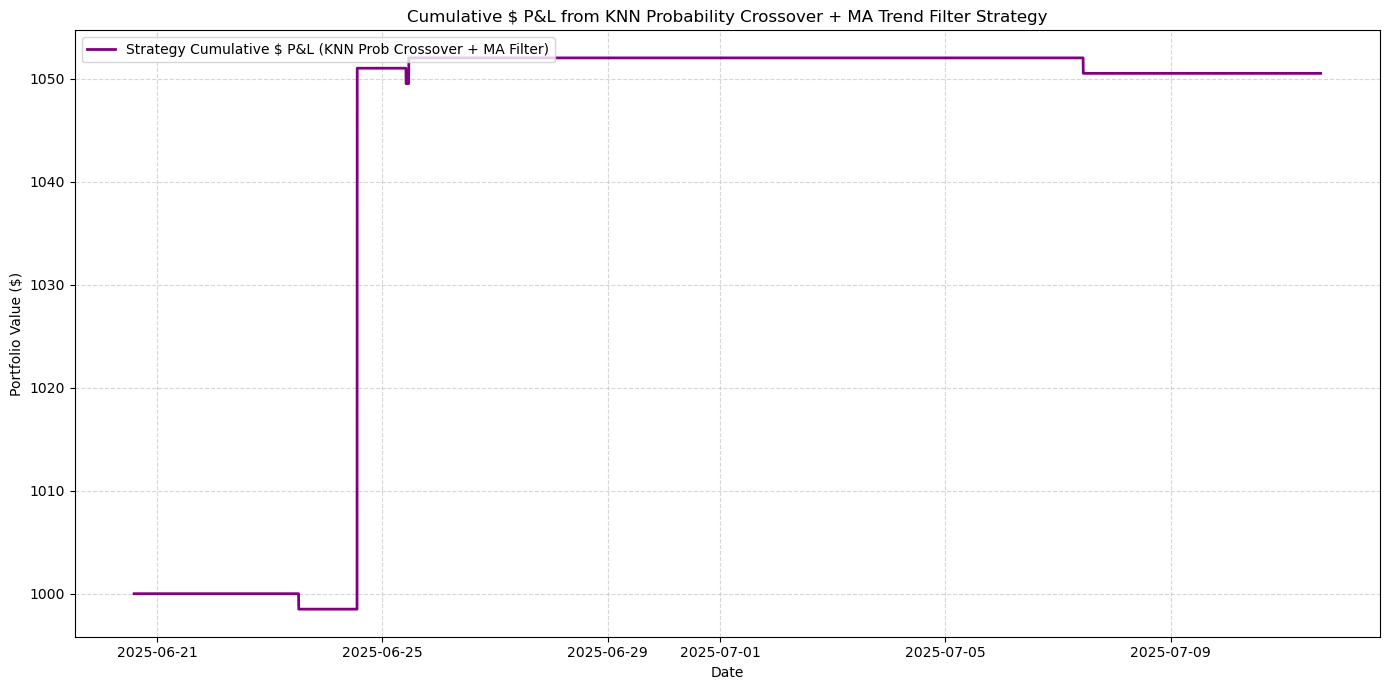

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# --- 1. Create rolling probabilities DataFrame (as before) ---
probs = knn.predict_proba(X_test)
class_order = knn.classes_
prob_df = pd.DataFrame(probs, columns=class_order, index=datafix.index[-len(X_test):])
prob_df['buy_prob_roll5'] = prob_df.get(1, pd.Series(0, index=prob_df.index)).rolling(5).mean()
prob_df['sell_prob_roll5'] = prob_df.get(-1, pd.Series(0, index=prob_df.index)).rolling(5).mean()

# --- 2. Correct crossover function ---
def crossover(series1, series2):
    prev1 = series1.shift(1)
    prev2 = series2.shift(1)
    cross_up = (prev1 <= prev2) & (series1 > series2)
    cross_down = (prev1 >= prev2) & (series1 < series2)
    return cross_up.astype(int) - cross_down.astype(int)

prob_df['knn_cross_signal'] = crossover(prob_df['buy_prob_roll5'], prob_df['sell_prob_roll5'])

# --- 3. Calculate the 20-period moving average and its trend ---
spread_series = datafix.loc[prob_df.index, 'spread']
prob_df['spread_ma20'] = spread_series.rolling(window=10).mean()
prob_df['spread_ma20_trend'] = prob_df['spread_ma20'].diff()

# --- 4. Filter buy/sell signals based on MA trend ---
prob_df['knn_cross_signal_filtered'] = prob_df['knn_cross_signal']
# Only allow buy signals when MA is trending up
prob_df.loc[
    (prob_df['knn_cross_signal'] == 1) & (prob_df['spread_ma20_trend'] <= 0),
    'knn_cross_signal_filtered'
] = 0
# Only allow sell signals when MA is trending down
prob_df.loc[
    (prob_df['knn_cross_signal'] == -1) & (prob_df['spread_ma20_trend'] >= 0),
    'knn_cross_signal_filtered'
] = 0

# --- 5. Backtest using the filtered signals ---
initial_capital = 1000
capital = initial_capital
position = 0  # 1 for long, 0 for flat
positions = []
portfolio = []
entry_spread = None
fee = 1.50  # dollar fee per trade

for idx, (dt, row) in enumerate(prob_df.iterrows()):
    sig = row['knn_cross_signal_filtered']
    spread = spread_series.loc[dt]
    if sig == 1 and position == 0:
        position = 1
        entry_spread = spread
        capital -= fee
    elif sig == -1 and position == 1:
        pnl = (spread - entry_spread) * 100
        capital += pnl
        capital -= fee
        position = 0
        entry_spread = None
    portfolio.append(capital)
    positions.append(position)

prob_df['Position'] = positions
prob_df['Portfolio'] = portfolio

total_return = prob_df['Portfolio'].iloc[-1] - initial_capital
print(f"Total Strategy $ Return (KNN Prob Crossover + MA Trend Filter): ${total_return:.2f}")

# --- 6. Plot the spread, rolling probabilities, MA, and signals ---
fig = go.Figure()

# Spread line
fig.add_trace(go.Scatter(
    x=spread_series.index, y=spread_series.values,
    mode='lines', name='Spread', line=dict(color='black', width=2)
))
# 20-period moving average
fig.add_trace(go.Scatter(
    x=prob_df.index, y=prob_df['spread_ma20'],
    mode='lines', name='Spread MA(20)', line=dict(color='orange', width=2, dash='dash')
))
# Rolling buy probability
fig.add_trace(go.Scatter(
    x=prob_df.index, y=prob_df['buy_prob_roll5'],
    mode='lines', name='Rolling Buy Prob (5)', line=dict(color='green', width=2, dash='dot')
))
# Rolling sell probability
fig.add_trace(go.Scatter(
    x=prob_df.index, y=prob_df['sell_prob_roll5'],
    mode='lines', name='Rolling Sell Prob (5)', line=dict(color='red', width=2, dash='dot')
))
# Buy signals (filtered)
buy_signals = prob_df[prob_df['knn_cross_signal_filtered'] == 1]
fig.add_trace(go.Scatter(
    x=buy_signals.index, y=spread_series.loc[buy_signals.index],
    mode='markers', name='Buy Signal',
    marker=dict(symbol='triangle-up', color='green', size=14, line=dict(color='black', width=1.5))
))
# Sell signals (filtered)
sell_signals = prob_df[prob_df['knn_cross_signal_filtered'] == -1]
fig.add_trace(go.Scatter(
    x=sell_signals.index, y=spread_series.loc[sell_signals.index],
    mode='markers', name='Sell Signal',
    marker=dict(symbol='triangle-down', color='red', size=14, line=dict(color='black', width=1.5))
))

fig.update_layout(
    title="Spread, KNN Rolling Probabilities, MA(20), and Filtered Buy/Sell Signals",
    xaxis_title="Date",
    yaxis_title="Spread / Probability",
    legend=dict(x=0.01, y=0.99),
    hovermode='x unified',
    template='plotly_white',
    width=1000,
    height=500
)
fig.show()

# --- 7. Plot cumulative P&L from the backtest ---
plt.figure(figsize=(14, 7))
plt.plot(prob_df.index, prob_df['Portfolio'], label='Strategy Cumulative $ P&L (KNN Prob Crossover + MA Filter)', color='purple', linewidth=2)
plt.title('Cumulative $ P&L from KNN Probability Crossover + MA Trend Filter Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


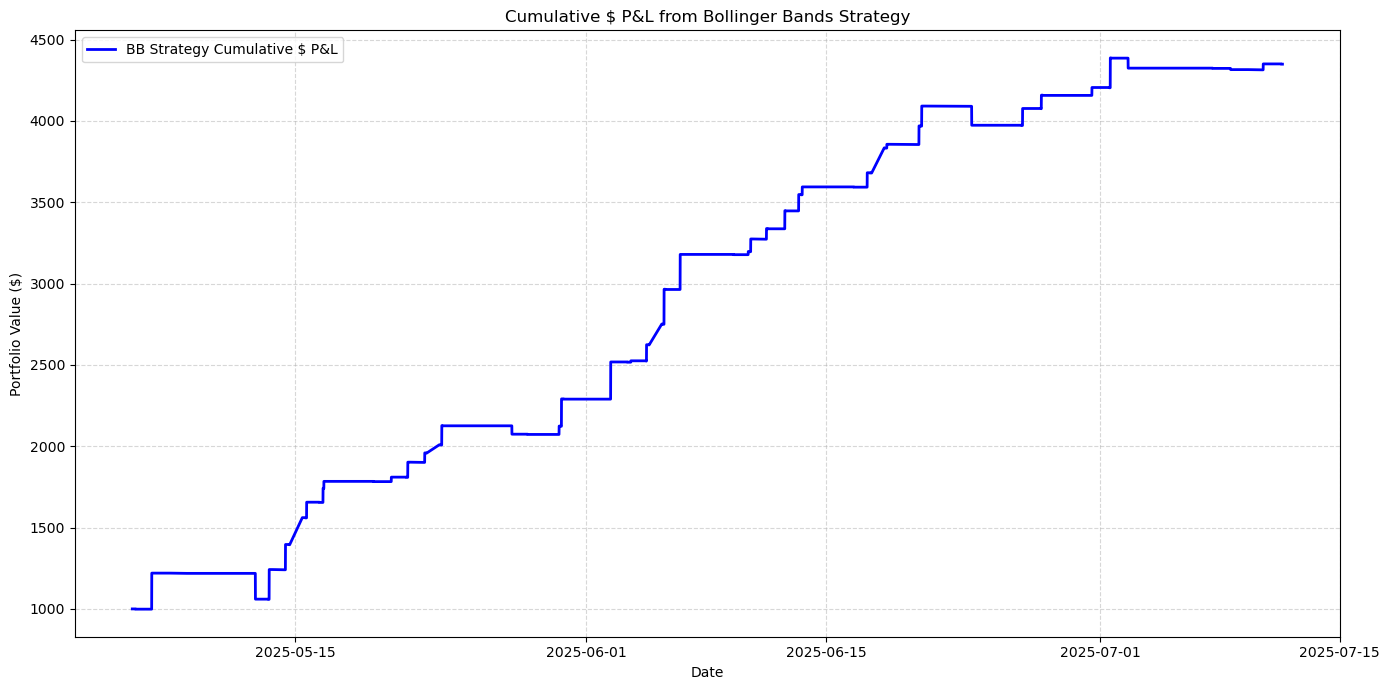

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(datafix.index, datafix['BB_Portfolio'], label='BB Strategy Cumulative $ P&L', color='blue', linewidth=2)
plt.title('Cumulative $ P&L from Bollinger Bands Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
